# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

/home/leopoldh/Documents/KTH/mlfs-book/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 21, 58, 24, 32483)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
try:
    with open('../../.venv/.secret/hopsworks-api-key.txt', 'r') as file:
        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
except:
    pass
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1180820
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.644606E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using ArrowFlight (1.17s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling
0,2024-11-20 00:00:00+00:00,4.25,0.1,15.542662,256.607483,lucerne,1.426667


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', "pm25_rolling"]])
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling,predicted_pm25
0,2024-11-20 00:00:00+00:00,4.25,0.1,15.542662,256.607483,lucerne,1.426667,1.172146


In [ ]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         1 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          1 non-null      float32            
 2   precipitation_sum            1 non-null      float32            
 3   wind_speed_10m_max           1 non-null      float32            
 4   wind_direction_10m_dominant  1 non-null      float32            
 5   city                         1 non-null      object             
 6   pm25_rolling                 1 non-null      float64            
 7   predicted_pm25               1 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(1), object(1)
memory usage: 176.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,4.25,0.1,15.542662,256.607483,lucerne,1.426667,1.172146,adligenswilerstrasse,switzerland,1


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         1 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          1 non-null      float32            
 2   precipitation_sum            1 non-null      float32            
 3   wind_speed_10m_max           1 non-null      float32            
 4   wind_direction_10m_dominant  1 non-null      float32            
 5   city                         1 non-null      object             
 6   pm25_rolling                 1 non-null      float64            
 7   predicted_pm25               1 non-null      float32            
 8   street                       1 non-null      object             
 9   country                      1 non-null      object             
 10  days_before_forecast_day     1 non-null      int64    

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

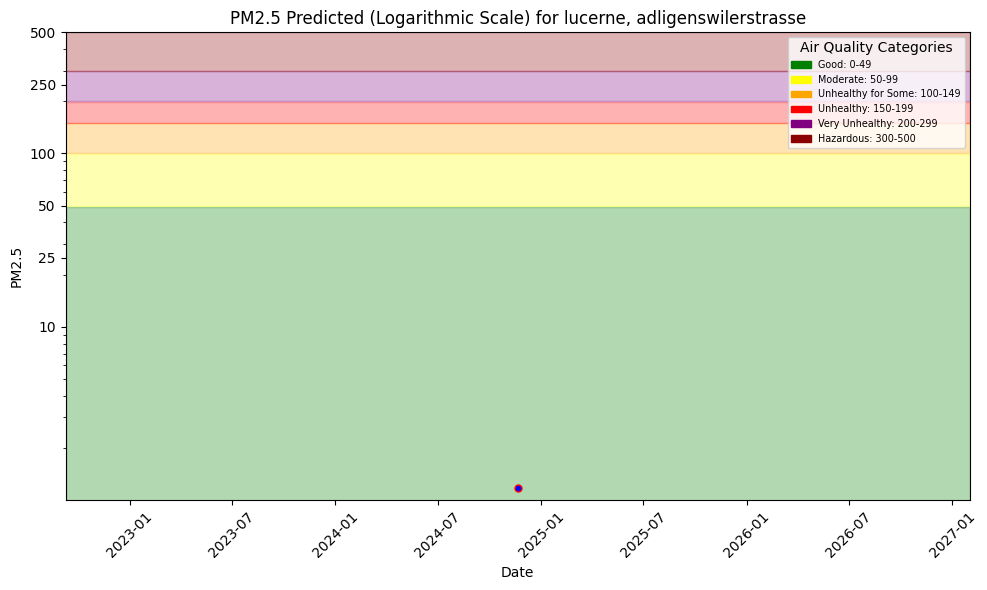

In [12]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:09 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180820/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x793ce798e720>, None)

In [15]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using ArrowFlight (0.92s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,4.250000,0.1,15.542662,256.607483,lucerne,1.426667,1.172146,adligenswilerstrasse,switzerland,1
1,2024-11-15 00:00:00+00:00,3.269167,0.0,3.710795,293.983429,lucerne,1.990000,4.113874,adligenswilerstrasse,switzerland,1
2,2024-11-10 00:00:00+00:00,7.227499,0.0,3.710795,349.464783,lucerne,3.416667,6.646132,adligenswilerstrasse,switzerland,1
3,2024-11-12 00:00:00+00:00,6.335834,3.4,12.744457,35.100521,lucerne,3.133333,2.128591,adligenswilerstrasse,switzerland,1
4,2024-11-17 00:00:00+00:00,5.333750,0.4,7.100310,27.216135,lucerne,2.396667,2.183602,adligenswilerstrasse,switzerland,1
5,2024-11-19 00:00:00+00:00,9.200000,0.1,14.982228,215.217682,lucerne,1.926667,2.108039,adligenswilerstrasse,switzerland,1
6,2024-11-13 00:00:00+00:00,4.737916,1.2,7.596341,19.584793,lucerne,2.360000,2.887985,adligenswilerstrasse,switzerland,1
7,2024-11-14 00:00:00+00:00,4.065000,0.0,6.112053,355.924774,lucerne,2.233333,4.112766,adligenswilerstrasse,switzerland,1
8,2024-11-11 00:00:00+00:00,7.452501,6.7,8.019601,345.304749,lucerne,3.383333,2.033866,adligenswilerstrasse,switzerland,1
9,2024-11-16 00:00:00+00:00,3.840000,0.0,4.044997,330.107605,lucerne,2.403333,4.106001,adligenswilerstrasse,switzerland,1


In [16]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using ArrowFlight (2.40s) 


,date,pm25,country,city,street,url
0,2020-01-10 00:00:00+00:00,3.15,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
1,2021-06-17 00:00:00+00:00,3.13,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
2,2024-07-02 00:00:00+00:00,1.10,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
3,2021-05-25 00:00:00+00:00,0.45,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
4,2021-05-09 00:00:00+00:00,1.00,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
...,...,...,...,...,...,...
1785,2024-09-02 00:00:00+00:00,2.04,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
1786,2022-07-03 00:00:00+00:00,1.48,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
1787,2019-12-10 00:00:00+00:00,1.84,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
1788,2023-01-16 00:00:00+00:00,0.40,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070


In [17]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-10 00:00:00+00:00,6.646132,2.90
7,2024-11-11 00:00:00+00:00,2.033866,2.95
2,2024-11-12 00:00:00+00:00,2.128591,1.23
5,2024-11-13 00:00:00+00:00,2.887985,2.52
6,2024-11-14 00:00:00+00:00,4.112766,2.22
0,2024-11-15 00:00:00+00:00,4.113874,2.47
8,2024-11-16 00:00:00+00:00,4.106001,2.50
3,2024-11-17 00:00:00+00:00,2.183602,2.40
4,2024-11-19 00:00:00+00:00,2.108039,1.00


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

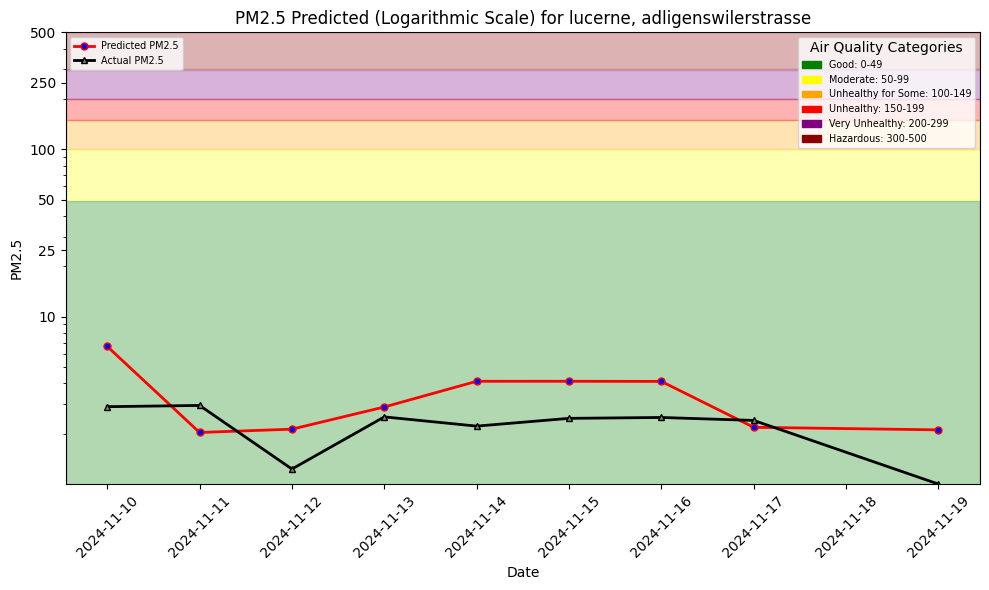

In [18]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---